# Data preparation 

In [13]:
import os

folder_path = "/kaggle/input/aflw-2000-headpose-estimation-dataset/AFLW2000-HeadPose/testimg"

def count_images(folder_path, extension=".jpg"):
 
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return 0
    
    image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(extension)]
    return len(image_files)

num_images = count_images(folder_path)

print(f"Number of .jpg images in the folder: {num_images}")


Number of .jpg images in the folder: 236


In [14]:
import os
import pandas as pd

# Load the CSV file
csv_file_path = '/kaggle/input/aflw-2000-headpose-estimation-dataset/AFLW2000-HeadPose/angle_data.csv'  # Replace with your actual CSV path
data = pd.read_csv(csv_file_path)

# Define the directory containing images
image_dir = "/kaggle/input/aflw-2000-headpose-estimation-dataset/AFLW2000-HeadPose/testimg"  # Replace with your actual image directory

# Get a list of all available image filenames in the directory
available_images = set(os.listdir(image_dir))  # Set of filenames in the directory

# Filter the dataset to include only rows where the image file exists in the directory
train_data = data[data['img_name'].isin(available_images)]

# Show how many rows are retained after filtering
print(f"Total valid image entries: {len(train_data)}")

# (Optional) Save the filtered dataset for later use
train_data.to_csv('test_angle_data.csv', index=False)


Total valid image entries: 236


# Inception Model

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, ReLU, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# Paths
train_csv_path = "/kaggle/input/landmarks-data/train_angle_data.csv"
train_images_path = "/kaggle/input/aflw-2000-headpose-estimation-dataset/AFLW2000-HeadPose/trainimg"
val_csv_path = "/kaggle/input/landmarks-data/test_angle_data.csv"
val_images_path = "/kaggle/input/aflw-2000-headpose-estimation-dataset/AFLW2000-HeadPose/testimg"

# 1. Load CSVs
train_data = pd.read_csv(train_csv_path)
val_data = pd.read_csv(val_csv_path)

# Helper function to load images and normalize angles
def load_data(data, img_dir):
    images, angles = [], []
    for _, row in data.iterrows():
        img_path = os.path.join(img_dir, row['img_name'])
        if os.path.exists(img_path):  # Check if the image exists
            img = tf.keras.utils.load_img(img_path, target_size=(224, 224))  # Resize to InceptionV3 size
            img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize images to [0, 1]
            images.append(img)
            # Normalize angles to a valid range
            normalized_angles = row[['pitch', 'yaw', 'roll']].to_numpy(dtype=np.float32)
            angles.append(normalized_angles)
    return np.array(images), np.array(angles)

# Load Train and Validation Data
train_images, train_angles = load_data(train_data, train_images_path)
val_images, val_angles = load_data(val_data, val_images_path)

# 2. Model Architecture with Additional Convolutional Layers and Dropout for Regularization
base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freezing initial layers to fine-tune only the last part of the model
# for layer in base_model.layers[:-50]:  # Fine-tune the last 15 layers
#     layer.trainable = False

# Adding custom convolutional layers after freezing the base model
x = base_model.output
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)                    
x = ReLU()(x)
x = Dropout(0.1)(x)
x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)

x = Conv2D(128, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)                   
x = ReLU()(x)
x = Dropout(0.2)(x)
x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.2)(x)

# Flatten and regression head
x = GlobalAveragePooling2D()(x)
x = Dense(1028, activation='relu')(x)
#x = Dropout(0.2)(x)  # Additional dropout to prevent overfitting
x = Dense(512, activation='relu')(x)
# = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# Output layer with 3 units for pitch, yaw, roll prediction
x = Dense(3, activation='linear')(x)

# Complete model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])

# 3. Training Setup
batch_size = 8
history = model.fit(
    train_images,  # Training without augmentations
    train_angles, 
    validation_data=(val_images, val_angles),
    epochs=20,
    batch_size=batch_size,
    verbose=1
)




Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 139s 514ms/step - accuracy: 0.4209 - loss: 349.4078 - val_accuracy: 0.4110 - val_loss: 1425.5001
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.6601 - loss: 264.9197 - val_accuracy: 0.6907 - val_loss: 309.1388
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.6781 - loss: 365.9438 - val_accuracy: 0.7712 - val_loss: 323.2826
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.6937 - loss: 195.8741 - val_accuracy: 0.7500 - val_loss: 124.6050
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.7179 - loss: 349.6126 - val_accuracy: 0.7331 - val_loss: 110.7186
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7321 - loss: 142.2892 - val_accuracy: 0.7373 - val_loss: 172.5794
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7370 - loss: 165.7486 - val_accuracy: 0.6737 - val_loss: 198.2837
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/ste

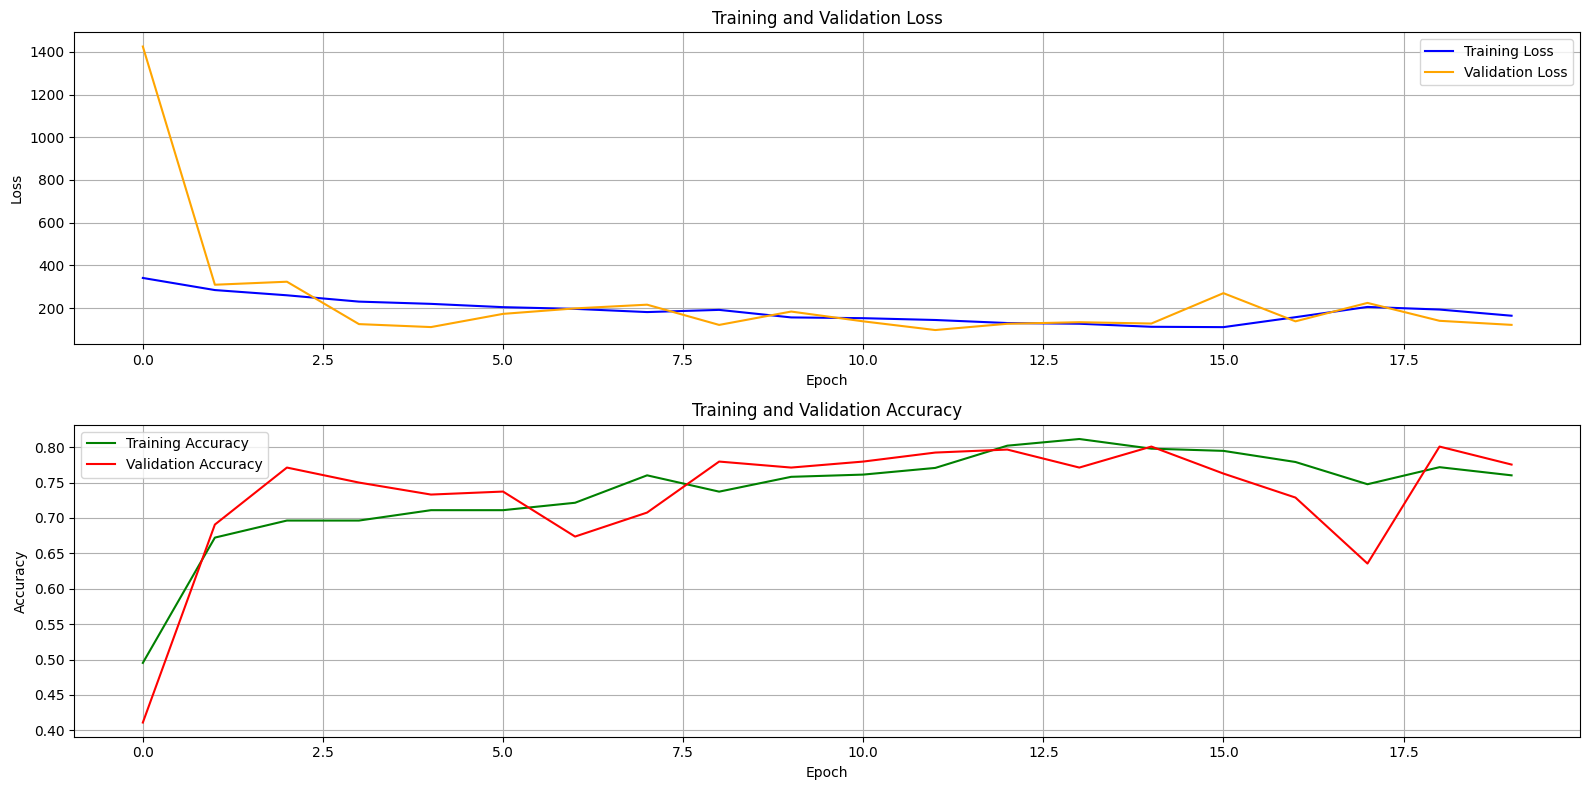

In [16]:
# 4. Plot Training and Validation Loss
plt.figure(figsize=(16, 8))

# Loss Plot
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy (Validation and Training)
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



In [18]:
# Saving the InceptionV3 model (architecture + weights)
model.save('inceptionv3_face_pose_model.h5')  # Saves the entire model (architecture + weights)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Pose: Turned to the left and tilted to the right.


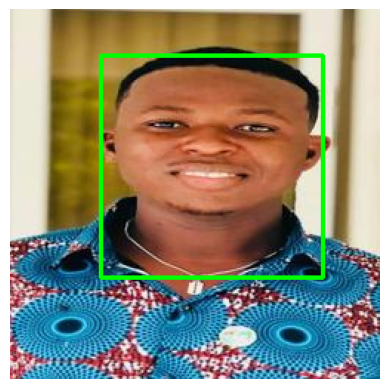

In [19]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the saved InceptionV3 model
model = tf.keras.models.load_model('/kaggle/working/inceptionv3_face_pose_model.h5')

# Load OpenCV's pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to describe the head pose based on pitch, yaw, and roll
def describe_head_pose(pitch, yaw, roll):
    pose_description = []

    # Pitch description
    if pitch < -15:
        pose_description.append("looking down")
    elif pitch > 15:
        pose_description.append("looking up")

    # Yaw description
    if yaw < -15:
        pose_description.append("turned to the right")
    elif yaw > 15:
        pose_description.append("turned to the left")

    # Roll description
    if roll < -10:
        pose_description.append("tilted to the left")
    elif roll > 10:
        pose_description.append("tilted to the right")

    # Combine all
    if not pose_description:
        return "The head is facing straight."
    return " and ".join(pose_description).capitalize() + "."

# Function to load, preprocess, and predict the pose of a new image
def predict_head_pose(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If faces are detected
    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    # Take the first detected face
    (x, y, w, h) = faces[0]

    # Draw a bounding box around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop the image to the detected face region
    face_img = img[y:y + h, x:x + w]

    # Convert the image to RGB (OpenCV loads it as BGR)
    face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

    # Preprocess the face for prediction
    face_img_resized = cv2.resize(face_img_rgb, (224, 224))  # Resize to InceptionV3 input size
    face_img_array = image.img_to_array(face_img_resized) / 255.0  # Normalize and convert to array

    # Expand dimensions to match the model input shape
    face_img_array = np.expand_dims(face_img_array, axis=0)

    # Make prediction
    predicted_pose = model.predict(face_img_array)

    # Extract pitch, yaw, and roll values from the prediction
    pitch, yaw, roll = predicted_pose[0]
    
    # Get the description of the head pose
    pose_description = describe_head_pose(pitch, yaw, roll)

    # Print the explanation
    print(f"Predicted Pose: {pose_description}")

    # Display the image with bounding box using Matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.axis('off')  # Turn off axes
    plt.show()

# Path to the new image for prediction
new_image_path = "/kaggle/input/aarondatasetvalidate/Aaron_Mone_0007.jpg"  # Replace with the correct path to the image in Kaggle
# Call the function to detect the face, draw the bounding box, and predict the pose
predict_head_pose(new_image_path)


# ResNet50

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, ReLU, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os



# 2. Model Architecture with Additional Convolutional Layers and Dropout for Regularization
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freezing initial layers to fine-tune only the last part of the model
# for layer in base_model.layers[:-50]:  # Fine-tune the last 15 layers
#     layer.trainable = False

# Adding custom convolutional layers after freezing the base model
x = base_model.output
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)                    
x = ReLU()(x)
x = Dropout(0.1)(x)
x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)

x = Conv2D(128, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)                   
x = ReLU()(x)
x = Dropout(0.2)(x)
x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.2)(x)

# Flatten and regression head
x = GlobalAveragePooling2D()(x)
x = Dense(1028, activation='relu')(x)
#x = Dropout(0.2)(x)  # Additional dropout to prevent overfitting
x = Dense(512, activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# Output layer with 3 units for pitch, yaw, roll prediction
x = Dense(3, activation='linear')(x)

# Complete model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])

# 3. Training Setup
batch_size = 8
historyresnet = model.fit(
    train_images,  # Training without augmentations
    train_angles, 
    validation_data=(val_images, val_angles),
    epochs=20,
    batch_size=batch_size,
    verbose=1
)



Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 248ms/step - accuracy: 0.5562 - loss: 280.3732 - val_accuracy: 0.4068 - val_loss: 8868.1846
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.6335 - loss: 240.0360 - val_accuracy: 0.5932 - val_loss: 187.9619
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.6398 - loss: 212.9669 - val_accuracy: 0.4831 - val_loss: 862.4966
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - accuracy: 0.6601 - loss: 214.9223 - val_accuracy: 0.6398 - val_loss: 247.1087
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - accuracy: 0.6544 - loss: 231.5074 - val_accuracy: 0.6949 - val_loss: 158.3657
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - accuracy: 0.6815 - loss: 281.8226 - val_accuracy: 0.6483 - val_loss: 156.6917
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - accuracy: 0.6550 - loss: 389.6820 - val_accuracy: 0.7415 - val_loss: 111.5660
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step

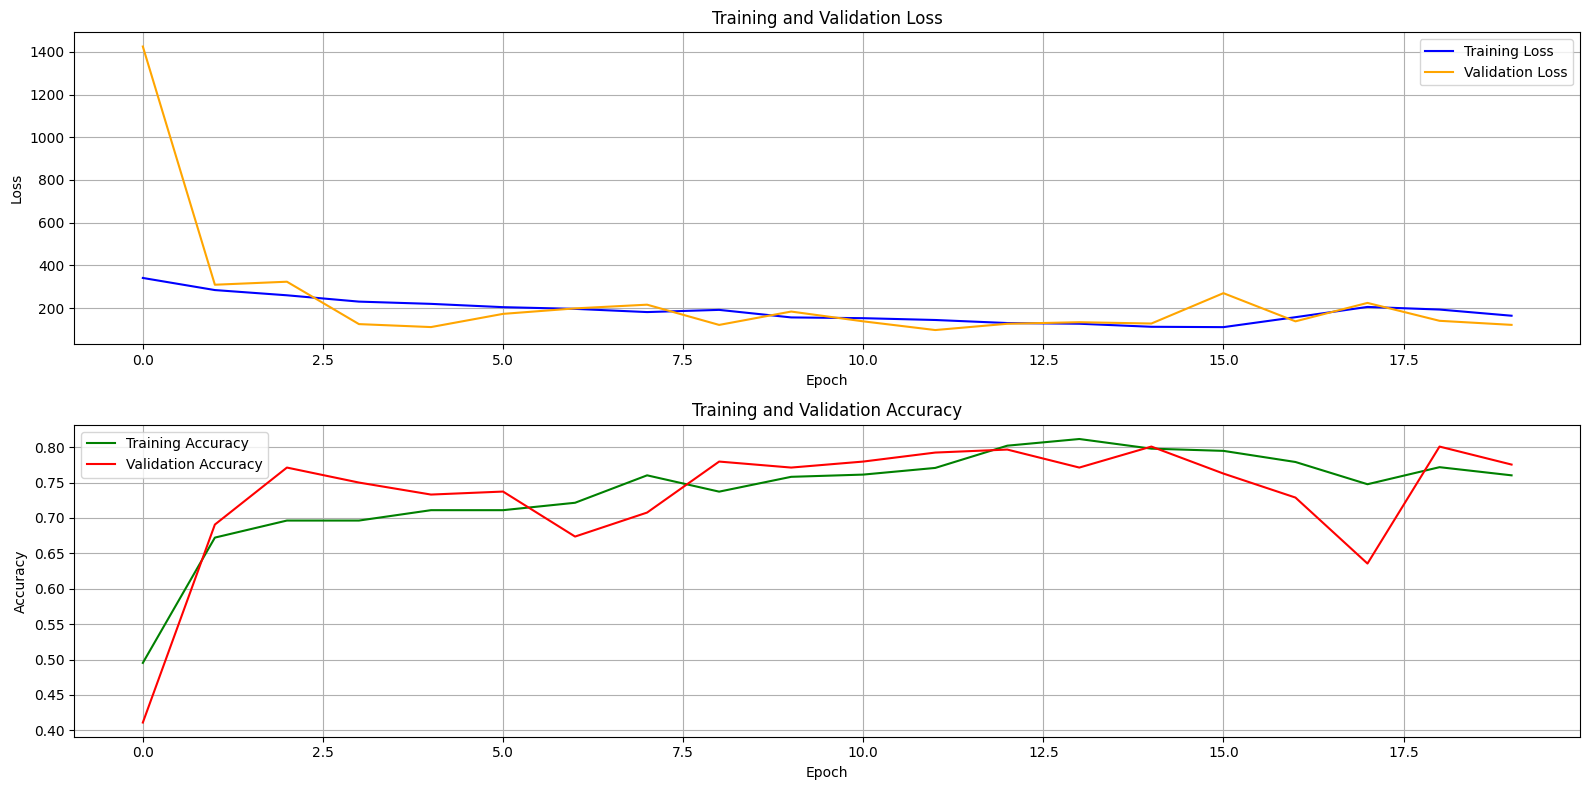

In [23]:
# 4. Plot Training and Validation Loss
plt.figure(figsize=(16, 8))

# Loss Plot
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy (Validation and Training)
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [25]:
# Saving the ResNet50 model
model.save('resnet50_face_pose_model.h5')  


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Pose: The head is facing straight.


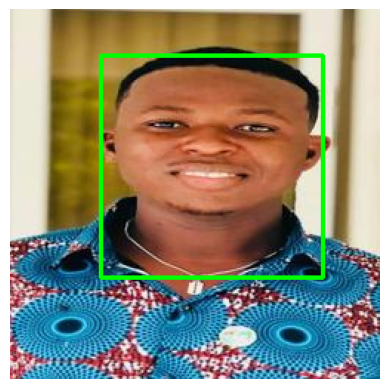

In [26]:


# Load the saved InceptionV3 model
model = tf.keras.models.load_model('/kaggle/working/resnet50_face_pose_model.h5')

# Load OpenCV's pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')



# Path to the new image for prediction
new_image_path = "/kaggle/input/aarondatasetvalidate/Aaron_Mone_0007.jpg"  # Replace with the correct path to the image in Kaggle
# Call the function to detect the face, draw the bounding box, and predict the pose
predict_head_pose(new_image_path)


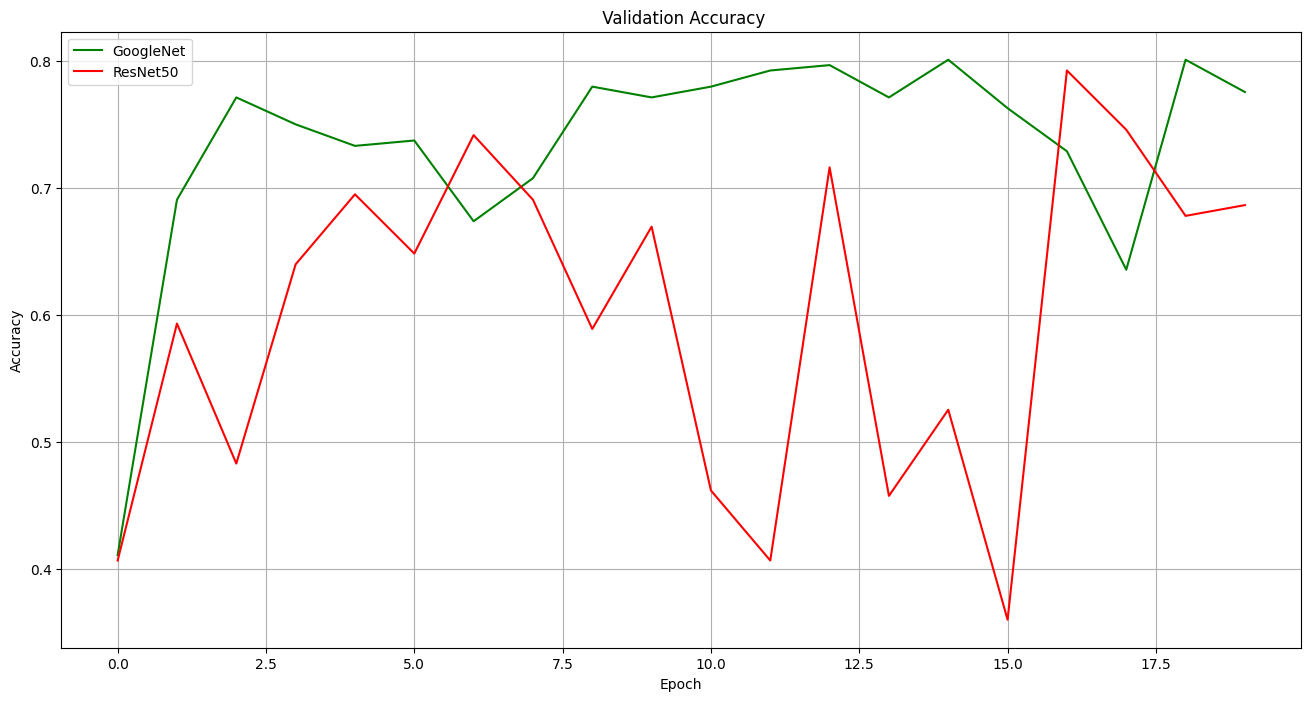

In [39]:
# Plot Accuracy (Validation and Training
plt.figure(figsize=(16, 8))

plt.plot(history.history['val_accuracy'], label='GoogleNet', color='green')
plt.plot(historyresnet.history['val_accuracy'], label='ResNet50', color='red')
plt.title(' Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout
plt.savefig("resultsFacePose.png")
plt.show()
